## Price and Sales correlation
- `Price` is weekly updated.
- `Sales` are daily recorded.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import gc
import os
import importlib

import pandas as pd
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# from utils import *
import utils


datapath = os.path.join('data')
cal_filename = 'calendar.csv'    # input
stv_filename = 'sales_train_validation.csv'    # input
ss_filename = 'sample_submission.csv'    # output
sellp_filename = 'sell_prices.csv'    # input
ste_filename = 'sales_train_evaluation.csv'

cal = pd.read_csv(os.path.join(datapath, cal_filename))
stv = pd.read_csv(os.path.join(datapath, stv_filename))
sellp = pd.read_csv(os.path.join(datapath, sellp_filename))
# Not necessary for prototype test
# ss = pd.read_csv(os.path.join(datapath, ss_filename))
# ste = pd.read_csv(os.path.join(datapath, ste_filename))

cal = utils.reduce_mem_usage(cal)
stv = utils.reduce_mem_usage(stv)
sellp = utils.reduce_mem_usage(sellp)
# ss = utils.reduce_mem_usage(ss)
# ste = utils.reduce_mem_usage(ste)

sales = stv
sales['id'] = sales['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))    # remove _validation or _evaluation

d_cols = [c for c in sales.columns if 'd_' in c]    # sales data columns
level_cols = sales.columns[sales.columns.str.contains("d_")==False].values    # level columns

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [2]:
#### Calendar data-type changing
cal = cal.assign(d=cal.d.str[2:].astype(int))
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1


In [3]:
sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                   var_name='d', value_name='demand')
sales = sales.assign(d=sales.d.str[2:].astype("int16"))

#### Merge by 'd' and 'wm_yr_wk'
sales = sales.merge(cal, how="left", on="d")
sales = sales.merge(sellp, how="left", on=["wm_yr_wk", "store_id", "item_id"])

sales_summary = sales.loc[:, ['id', 'd', 'date', 'wm_yr_wk', 'demand', 'sell_price']]
sales_summary = sales_summary.dropna(axis=0)

sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [4]:
sales_summary.head()

,id,d,date,wm_yr_wk,demand,sell_price
7,HOBBIES_1_008_CA_1,1,2011-01-29,11101,12,0.459961
8,HOBBIES_1_009_CA_1,1,2011-01-29,11101,2,1.559570
9,HOBBIES_1_010_CA_1,1,2011-01-29,11101,0,3.169922
11,HOBBIES_1_012_CA_1,1,2011-01-29,11101,0,5.980469
14,HOBBIES_1_015_CA_1,1,2011-01-29,11101,4,0.700195


In [179]:
# pool = sales_summary['id'].unique()
pool[np.random.choice(len(pool), 10)]


array(['FOODS_1_052_WI_3', 'FOODS_2_245_CA_3', 'FOODS_3_628_WI_1',
       'FOODS_3_551_CA_2', 'HOUSEHOLD_2_074_WI_1', 'FOODS_2_133_CA_3',
       'HOUSEHOLD_2_402_TX_3', 'FOODS_3_736_WI_3', 'HOBBIES_2_069_TX_3',
       'HOUSEHOLD_2_384_CA_2'], dtype=object)

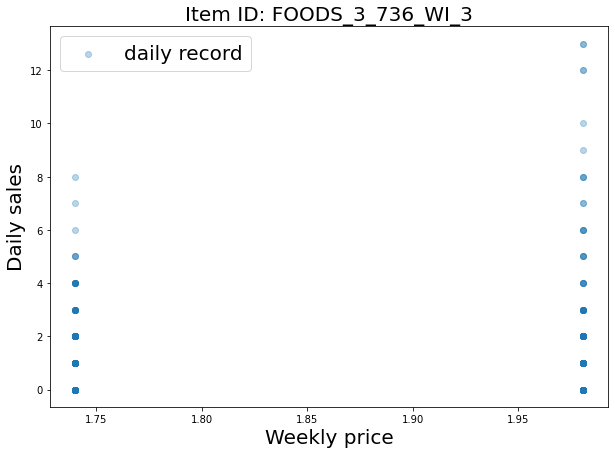

In [184]:
full_id = 'FOODS_3_736_WI_3'   # Good example

tmp = sales_summary[sales_summary['id']==full_id]

x, y = tmp['sell_price'], tmp['demand']


plt.figure(0, figsize=(10,7))
plt.scatter(x, y, label='daily record', alpha=0.3)
plt.title('Item ID: {}'.format(full_id), fontsize=20)
plt.xlabel('Weekly price', fontsize=20)
plt.ylabel('Daily sales', fontsize=20)
plt.legend(fontsize=20)

In [ ]:
d = {}
d['day_price'] = sales_summary.groupby(['id', 'd'])['sell_price']
d['day_demand'] = sales_summary.groupby(['id', 'd'])['demand']
df_price_sales = pd.DataFrame(d, dtype='float32')

grouped = df_price_sales.groupby('id')
d = {}
d['corr'] = grouped.apply(lambda x: stats.linregress(x['day_price'], x['day_demand'])[2])    # correlation
df_corr = pd.DataFrame(d)    # 30,490 items' correlation

In [190]:
a = sales_summary.groupby(['id'])['sell_price'].unique()

In [196]:
a[a.apply(lambda x: len(x))==1]

id
FOODS_1_014_CA_1        [0.98]
FOODS_1_014_CA_2        [0.98]
FOODS_1_014_CA_3        [0.98]
FOODS_1_014_CA_4        [0.98]
FOODS_1_014_TX_1        [0.98]
                         ...  
HOUSEHOLD_2_516_TX_1    [5.94]
HOUSEHOLD_2_516_TX_3    [5.94]
HOUSEHOLD_2_516_WI_1    [5.94]
HOUSEHOLD_2_516_WI_2    [5.94]
HOUSEHOLD_2_516_WI_3    [5.94]
Name: sell_price, Length: 8371, dtype: object

In [7]:
sales_summary.shape

(46027957, 6)

## Compute correlation coefficient between sales-for-week and weekly-price per an item.

In [5]:
d = {}
d['week_sell_price'] = sales_summary.groupby(['id', 'wm_yr_wk'])['sell_price'].mean()
d['week_sum_demand'] = sales_summary.groupby(['id', 'wm_yr_wk'])['demand'].sum()
df_price_sales = pd.DataFrame(d, dtype='float32')

grouped = df_price_sales.groupby('id')
d = {}
d['corr'] = grouped.apply(lambda x: stats.linregress(x['week_sell_price'], x['week_sum_demand'])[2])    # correlation
df_corr = pd.DataFrame(d)    # 30,490 items' correlation

selected_ids = df_corr[df_corr['corr']<-0.6].index

In [6]:
selected_ids.shape

(454,)

Text(0, 0.5, 'correlation')

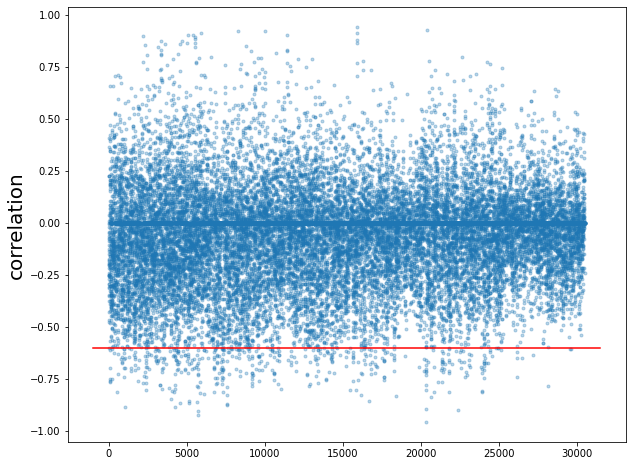

In [213]:
plt.figure(0, figsize=(10,8))
plt.plot(df_corr['corr'].to_numpy(), '.', alpha=0.3)
plt.plot([-1000, 31500],[-0.6,-0.6], 'r')
plt.ylabel('correlation', fontsize=20)

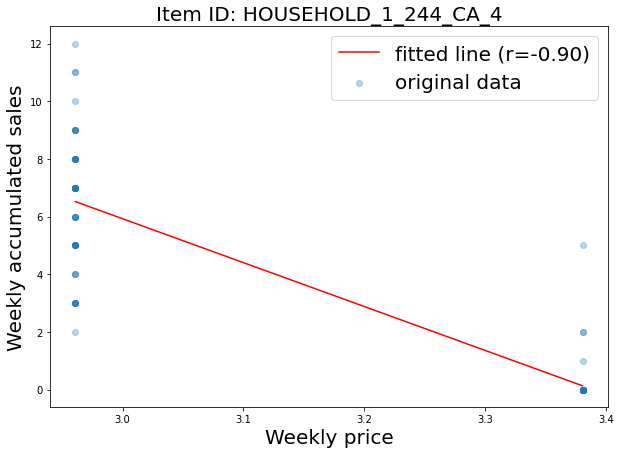

In [218]:
# full_id = 'FOODS_1_107_TX_3'
# full_id = 'FOODS_2_021_TX_1'    # Good example
# full_id = 'FOODS_2_299_WI_1'
# full_id = 'HOUSEHOLD_2_279_TX_3'
# full_id = 'HOBBIES_1_335_WI_1'
full_id = 'HOUSEHOLD_1_244_CA_4'
tmp = df_price_sales.loc[full_id]

x, y = tmp['week_price'], tmp['week_sum_demand']
regs = stats.linregress(x, y)

plt.figure(0, figsize=(10,7))
plt.scatter(x, y, label='original data', alpha=0.3)
plt.plot(x, regs[0]*x + regs[1], 'r', label='fitted line (r={:.2f})'.format(regs[2]))
plt.title('Item ID: {}'.format(full_id), fontsize=20)
plt.xlabel('Weekly price', fontsize=20)
plt.ylabel('Weekly accumulated sales', fontsize=20)
plt.legend(fontsize=20)

In [217]:
df_corr[df_corr['corr']<-0.6][400:420]

,corr
id,
HOUSEHOLD_1_176_WI_3,-0.627134
HOUSEHOLD_1_180_CA_3,-0.809977
HOUSEHOLD_1_182_CA_1,-0.603616
HOUSEHOLD_1_182_CA_4,-0.709830
HOUSEHOLD_1_182_TX_1,-0.656245
HOUSEHOLD_1_182_WI_1,-0.721414
HOUSEHOLD_1_182_WI_2,-0.667435
HOUSEHOLD_1_203_WI_2,-0.677004
HOUSEHOLD_1_230_TX_1,-0.615341


In [214]:
a = df_corr[df_corr['corr']<-0.6]
b = [ind.split('_')[0]=='FOODS' for ind in a.index]
np.sum(b), len(b)

(308, 454)

## Feature engineering
- Task: Predict accumulated sales per a week.
- Get some categorical features

In [ ]:
'''
Preprosessing and add derived features on sales 
'''

sales = utils.prep_sales(sales)
sales.head()

In [ ]:
sales = sales.merge(cal, how="left", on="d")
sales = sales.merge(sellp, how="left", on=["wm_yr_wk", "store_id", "item_id"])

sales_summary = sales.loc[:, ['id', 'd', 'date', 'wm_yr_wk', 'demand', 'sell_price']]
sales_summary = sales_summary.dropna(axis=0)

sales.head()

In [155]:
import utils

cal = pd.read_csv(os.path.join(datapath, cal_filename))
cal = utils.reduce_mem_usage(cal)

cal = utils.categorize_calendar(cal)
cal.head()



Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to  0.03 Mb (84.4% reduction)


,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


In [ ]:
# sales = sales.dropna(subset=['sell_price'])

In [150]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
7,HOBBIES_1_008_CA_1,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.459961
8,HOBBIES_1_009_CA_1,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.559570
9,HOBBIES_1_010_CA_1,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,3.169922
11,HOBBIES_1_012_CA_1,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,5.980469
14,HOBBIES_1_015_CA_1,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,4,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.700195


In [52]:
d

,corr
id,
FOODS_1_001_CA_1,-0.241774
HOUSEHOLD_2_516_WI_3,0.000000


In [110]:
def filter_id_from_sales(df, full_id):
    return df[df['id']==full_id]

def weekly_merge(df):
    d = {}
    d['week_price'] = df.groupby('wm_yr_wk')['sell_price'].mean()
    d['week_sum_demand'] = df.groupby('wm_yr_wk')['demand'].sum()
    return pd.DataFrame(d)

# There are 30,490 different items


list_of_ids = sales_summary['id'].unique()
for inum, full_id in tqdm(enumerate(list_of_ids)):
#     full_id = 'HOBBIES_1_001_CA_1'
    tmp_df = filter_id_from_sales(sales_summary, full_id)
    
    week_df = weekly_merge(tmp_df)

    x = week_df.to_numpy().transpose()

    #Regression Line (regr[0] is slope, regr[1] is intercept, and regr[2] is correlation)
    regr = stats.linregress(x[0], x[1]) 
    regr_line = regr[1] + regr[0]*x[0] #Generate regression line data
    corr12 = regr[2] #correlation from regression output
    print('ID:{}\tcorrelation between week_sum_demand vs. week_price: {}'.format(full_id, corr12))
    break

ID:HOBBIES_1_001_CA_1	correlation between week_sum_demand vs. week_price: -0.18195920580482097



In [115]:
# sales_summary.groupby('id')
sales_summary

,id,d,date,wm_yr_wk,demand,sell_price
0,HOBBIES_1_001_CA_1,1,2011-01-29,11101,0,NaN
1,HOBBIES_1_002_CA_1,1,2011-01-29,11101,0,NaN
2,HOBBIES_1_003_CA_1,1,2011-01-29,11101,0,NaN
3,HOBBIES_1_004_CA_1,1,2011-01-29,11101,0,NaN
4,HOBBIES_1_005_CA_1,1,2011-01-29,11101,0,NaN
...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3,1913,2016-04-24,11613,1,2.980469
58327366,FOODS_3_824_WI_3,1913,2016-04-24,11613,0,2.480469
58327367,FOODS_3_825_WI_3,1913,2016-04-24,11613,0,3.980469
58327368,FOODS_3_826_WI_3,1913,2016-04-24,11613,3,1.280273


Text(0, 0.5, 'sales')

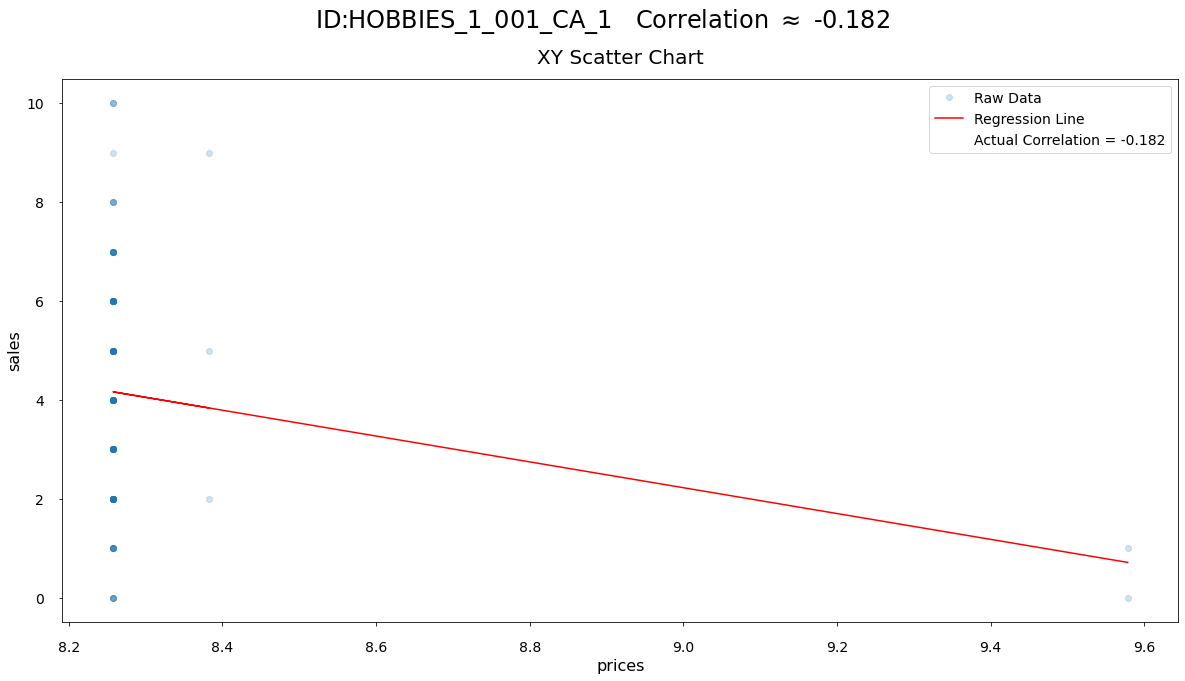

In [104]:
'''Draw a scatter chart of two series and fit a regression line'''
#Set up Figure with two subplots
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('ID:{}\t'.format(full_id) + r'Correlation $\approx$ ' + '{:0.3f}'.format(corr12), y=0.98, fontsize=24)

#Scatter Chart
ax.plot(x[0], x[1], 'o', alpha=0.2, label='Raw Data') #Plot the generated data
ax.plot(x[0], regr_line, 'r-', label='Regression Line') #Plot the regression line
ax.plot([],[], alpha=0, label='Actual Correlation = '+'{:0.3f}'
                                     .format(corr12)) #Empty plot just to add actual corr to legend
ax.set_title('XY Scatter Chart', fontsize=20, pad=15)
# ax.set_aspect('equal')
ax.tick_params(axis='both', labelsize=14, pad=15)
ax.legend(fontsize=14)
ax.set_xlabel('prices', fontsize=16)
ax.set_ylabel('sales', fontsize=16)


In [21]:
sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [22]:
sales.shape

(58327370, 22)